# Predicting heart disease risk

This notebook will explore medical data and compare several machine learning models in order to find a model capable of determining heart disease risk in patients. Our company has a shortage of cardiologists and needs to prioritize patients appropriately. Those determined to be at risk will be given precedence when scheduling appointments, meaning those who are determined to not be at risk may have their appointments rescheduled as needed. I will use the dataset available at https://www.kaggle.com/fedesoriano/heart-failure-prediction to train and test four machine learning algorithms, picking the best performing one for use in this application. This is a classification problem, so I will compare SVC, K-Nearest Neighbors, Random Forest, and Logistic Regression.

The model will be considered successful if we can reach a minimum cross-validated accuracy of 80% at predicting whether or not a patient has heart disease. Because false positives and false negatives have an extremely high cost when it comes to treating heart disease, the model also needs to have a minimum cross-validated precision and minimum cross-validated recall of 80%.

### Data Dictionary

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
# EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
#Load data
df = pd.read_csv("heart-disease.csv")

Below is a preview of the data loaded from heart-disease.csv:

In [3]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Below is info on the count and data types for each each attribute:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Below is a count of missing values for each attribute.

In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Below are statistics for each numerical attribute. While there are technically no missing values, Cholesterol and RestingBP have minimums of 0, indicating that 0 may have been incorrectly recorded for several patients. I will replace those 0's with the mean of the Cholesterol and RestingBP attributes, leaving out the 0's in the mean calculation.

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
# Cholesterol and RestingBP have 0's that are likely missing values incorrectly recorded as 0. You cannot have 0 cholesterol
# nor 0 RestingBP. Will replace 0's with NaN, then fillna with the mean of each column.
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)
df["RestingBP"] = df["RestingBP"].replace(0, np.nan)

In [8]:
df["Cholesterol"].fillna(df["Cholesterol"].mean(), inplace=True)
df["RestingBP"].fillna(df["RestingBP"].mean(), inplace=True)

Below are the revised statistics after replacing those 0's with the mean. Cholesterol's mean has increased significantly because 172 0's were replaced with the mean of the other cholesterol values. RestingBP's mean has not changed much because there was only one 0 that was replaced with the mean.

In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,244.635389,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.989932,53.318029,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,244.635389,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Below are histograms showing the distributions for all numerical data. The histograms for FastingBS and HeartDisease can be ignored since they are categorical data indicated by either a 0 or a 1. Except for Oldpeak, the other histograms have mostly normal distributions. This is important because one of the models we will be testing, Logistic Regression, assumes a normal distribution in its calculations.

C:\Users\steve\AppData\Local\Temp/ipykernel_28160/4283695574.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'FastingBS'}>,
        <AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>],
       [<AxesSubplot:title={'center':'HeartDisease'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

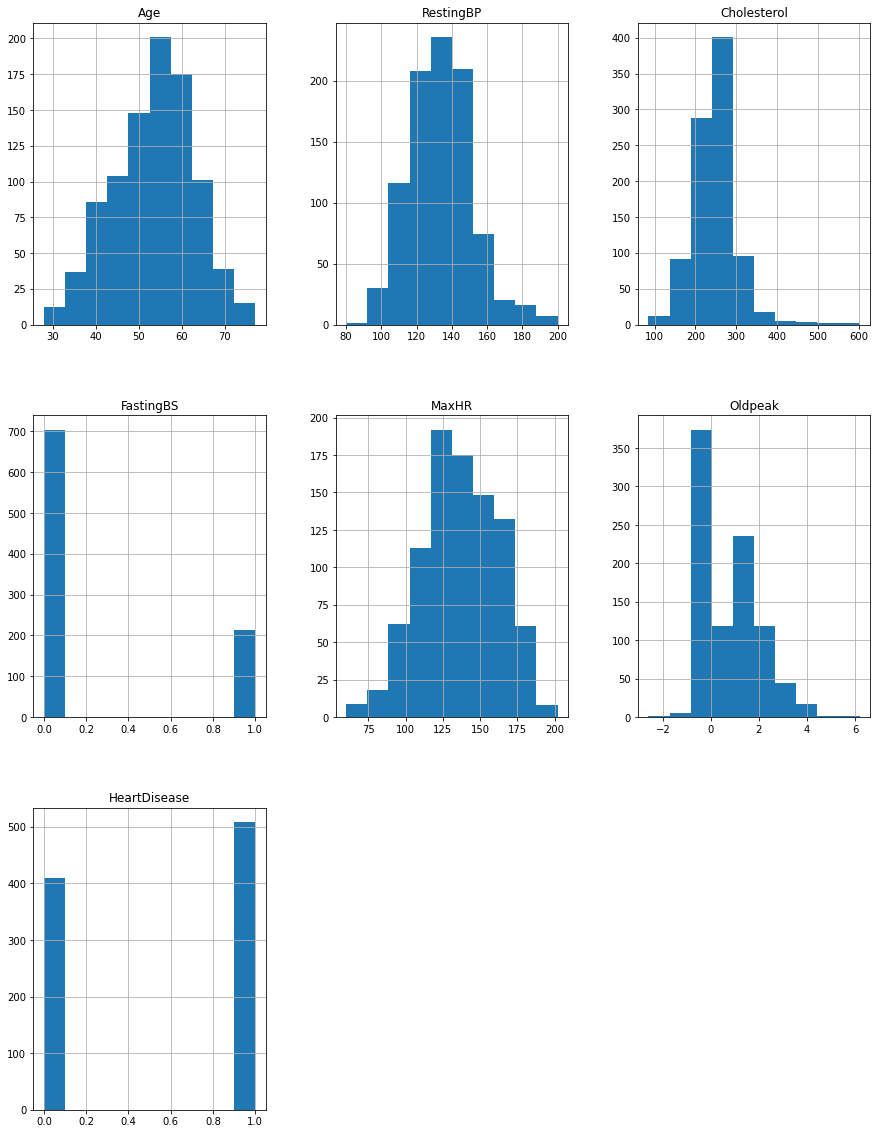

In [10]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

In order to make a correlation matrix that determines which attributes have the strongest positive or negative correlation with heart disease, I will first need to convert the categorical attributes into numerical data consisting of 0's and 1's for the corresponding categories.

In [11]:
# Make all data nummerical
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                  one_hot,
                                 categorical_features)],
                               remainder="passthrough")

transformed_df = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df)

# Rename transformed_df columns to match attribute names
transformed_df.rename(columns = {0:"Sex_F", 1:"Sex_M", 2:"ChestPain_ASY", 3:"ChestPain_ATA", 4:"ChestPain_NAP", 5:"ChestPain_TA",
                                6:"ECG_LVH", 7:"ECG_Normal", 8:"ECG_ST", 9:"ExercseAngina_No", 10:"ExerciseAngina_Yes",
                                11:"ST_Down", 12:"ST_Flat", 13:"ST_Up", 14:"Age", 15:"RestingBP", 16:"Cholesterol",
                                17:"FastingBS", 18:"MaxHR", 19:"Oldpeak", 20:"HeartDisease"}, inplace=True)
transformed_df

,Sex_F,Sex_M,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA,ECG_LVH,ECG_Normal,ECG_ST,ExercseAngina_No,...,ST_Down,ST_Flat,ST_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,40.0,140.0,289.0,0.0,172.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49.0,160.0,180.0,0.0,156.0,1.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,37.0,130.0,283.0,0.0,98.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,48.0,138.0,214.0,0.0,108.0,1.5,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,54.0,150.0,195.0,0.0,122.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,45.0,110.0,264.0,0.0,132.0,1.2,1.0
914,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,68.0,144.0,193.0,1.0,141.0,3.4,1.0
915,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,57.0,130.0,131.0,0.0,115.0,1.2,1.0
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,57.0,130.0,236.0,0.0,174.0,0.0,1.0


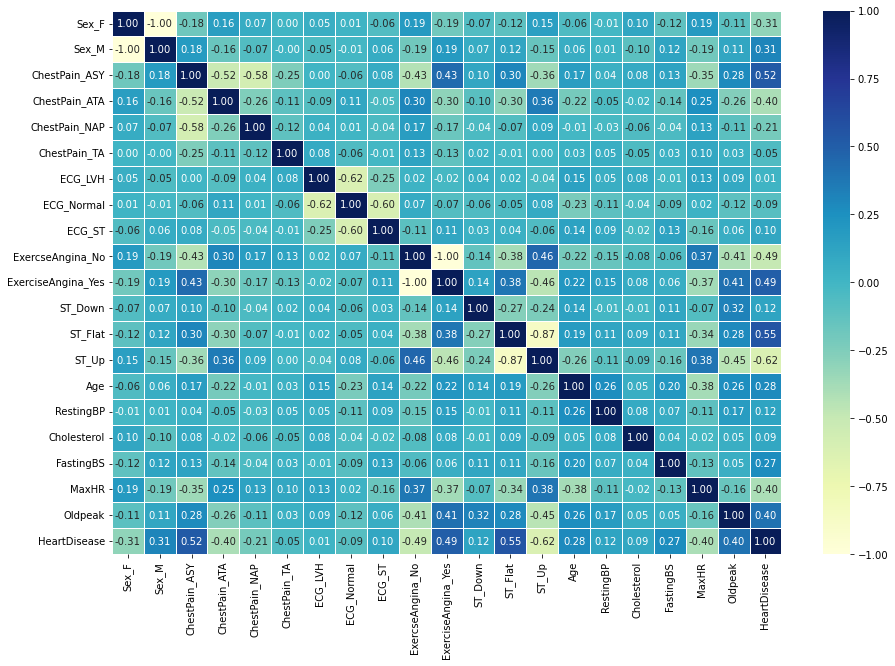

In [12]:
# Make a correlation matrix
corr_matrix = transformed_df.corr()
fig, ax =plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                annot = True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");

Based on the correlation matrix above, we can see that heart disease correlates positively with males, asymptomatic chest pain, exercise induced angina, a flat ST slope, age, fasting blood sugar, and oldpeak. It correlates negatively with females, atypical angina, no exercise induced angina, an upwards ST slope, and max heart rate.

Below is a scatterplot showing the correlation between age and max heart rate. As age increases, max heart rate tends to decrease. This also confirms that heart disease risk tends to increase with age and as max heart rate decreases.

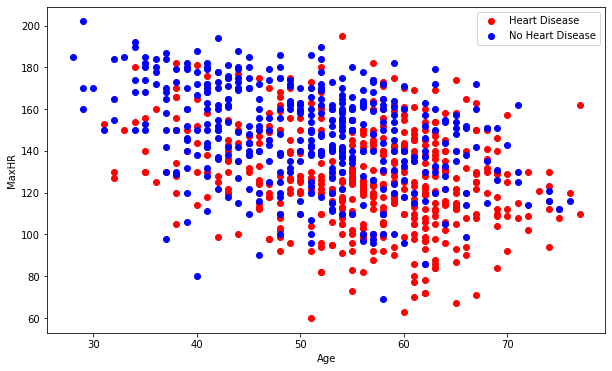

In [13]:
plt.figure(figsize=(10, 6))

plt.scatter(transformed_df.Age[transformed_df.HeartDisease==1],
           transformed_df.MaxHR[transformed_df.HeartDisease==1],
           c="red")

plt.scatter(transformed_df.Age[transformed_df.HeartDisease==0],
           transformed_df.MaxHR[transformed_df.HeartDisease==0],
           c="blue")

plt.xlabel("Age")
plt.ylabel("MaxHR")
plt.legend(["Heart Disease", "No Heart Disease"]);

We will now split the data into independent variables (x) and dependent variables (y) for training and testing our machine learning models.

Independent Variables (x):

In [14]:
# Split data into x and y
x = transformed_df.drop("HeartDisease", axis=1)

y = transformed_df["HeartDisease"]

In [15]:
x

,Sex_F,Sex_M,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA,ECG_LVH,ECG_Normal,ECG_ST,ExercseAngina_No,ExerciseAngina_Yes,ST_Down,ST_Flat,ST_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,40.0,140.0,289.0,0.0,172.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,0.0,156.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,37.0,130.0,283.0,0.0,98.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,48.0,138.0,214.0,0.0,108.0,1.5
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,150.0,195.0,0.0,122.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,45.0,110.0,264.0,0.0,132.0,1.2
914,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,68.0,144.0,193.0,1.0,141.0,3.4
915,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,57.0,130.0,131.0,0.0,115.0,1.2
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,57.0,130.0,236.0,0.0,174.0,0.0


Dependent Variable (y):

In [16]:
y

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
913    1.0
914    1.0
915    1.0
916    1.0
917    0.0
Name: HeartDisease, Length: 918, dtype: float64

Then we will split the data into train and test sets:



In [17]:
# Split data into train and test sets
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.2)

X Train:

In [18]:
x_train

,Sex_F,Sex_M,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA,ECG_LVH,ECG_Normal,ECG_ST,ExercseAngina_No,ExerciseAngina_Yes,ST_Down,ST_Flat,ST_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
795,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,42.0,120.0,240.000000,1.0,194.0,0.8
25,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,36.0,130.0,209.000000,0.0,178.0,0.0
84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,56.0,150.0,213.000000,1.0,125.0,1.0
10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,37.0,130.0,211.000000,0.0,142.0,0.0
344,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,51.0,120.0,244.635389,1.0,104.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,48.0,120.0,254.000000,0.0,110.0,0.0
270,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,120.0,225.000000,0.0,140.0,0.0
860,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,60.0,130.0,253.000000,0.0,144.0,1.4
435,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,60.0,152.0,244.635389,0.0,118.0,0.0


Y Train:

In [19]:
y_train, len(y_train)

(795    0.0
 25     0.0
 84     1.0
 10     0.0
 344    1.0
       ... 
 106    0.0
 270    0.0
 860    1.0
 435    0.0
 102    1.0
 Name: HeartDisease, Length: 734, dtype: float64,
 734)

We're going to try 4 different machine learning models:
1. Logistic Regression
2. K-Nearest Neighbors Classifier
3. Random Forest Classifier
4. SVC

In [20]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "SVC": SVC()}

# Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    x_train : training data (no labels)
    x_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        #Fit the model to the data
        model.fit(x_train, y_train)
        #Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [21]:
model_scores = fit_and_score(models=models,
                            x_train=x_train,
                            x_test=x_test,
                            y_train=y_train,
                            y_test=y_test)

model_scores

C:\Users\steve\OneDrive\Desktop\Capstone\heart-disease-risk\env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8641304347826086,
 'KNN': 0.6739130434782609,
 'Random Forest': 0.8695652173913043,
 'SVC': 0.6630434782608695}

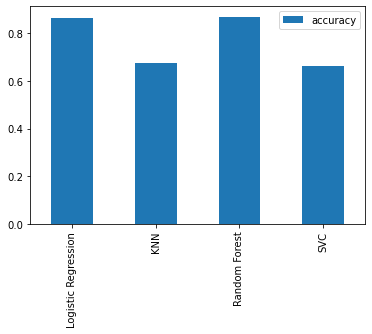

In [22]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

Above are the accuracy results for our four models. KNN and SVC are well below our goal of 80%, so we can probably cross those of our list of eligible models. Logistic Regression and Random Forest are both about 86%, so we will tune hyperparameters using RandomizedSearchCV to see if either model's accuracy can be improved.

In [23]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
               "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
          "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf": np.arange(1, 20, 2)}

In [24]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

Logistic Regression's accuracy is below and remains the same after tuning:

In [25]:
rs_log_reg.score(x_test, y_test)

0.8641304347826086

In [26]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

Random Forest's accuracy is below and drops a little after tuning:

In [27]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(x_test, y_test)

0.8586956521739131

Since Logistic Regression's accuracy is the highest after using RandomizedSearchCV, we will attempt to improve it one more time using GridSearchCV to tune it.

In [28]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
               "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=log_reg_grid,
                         cv=5,
                         verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(x_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Below is Logistic Regression's accuracy after tuning the model with GridSearchCV. It has increased slightly:

In [29]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(x_test, y_test)

0.8695652173913043

Since Logistic Regression has the highest accuracy after tuning hyperparameters, we will cross validate results to ensure the minimum accuracy, precision, and recall percentages are met.

Below is a confusion matrix that compares our y_test data with predictions made by our model. You can see that there were 15 cases where no heart disease was mistakenly predicted, and 9 cases where heart disease was mistakenly predicted.

In [30]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(x_test)

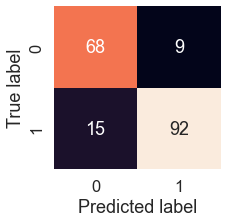

In [31]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot=True,
                    cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
plot_conf_mat(y_test, y_preds)

Below is a bar graph showing our cross-validated metrics. Accuracy, precision, and recall are all at least 80%, so our minimum evaluation metrics have been met. Precision and recall are important in classifying heart disease. The closer precision is to 1, the lower the false positive rate is. The closer recall is to 1, the lower the false negative rate is.

In [32]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.38566204211634725,
                        solver="liblinear")

In [33]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                        x,
                        y,
                        cv=5,
                        scoring="accuracy")
cv_acc = np.mean(cv_acc)

In [34]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                        x,
                        y,
                        cv=5,
                        scoring="precision")
cv_precision=np.mean(cv_precision)

In [35]:
# Cross-validated recall
cv_recall = cross_val_score(clf,
                        x,
                        y,
                        cv=5,
                        scoring="recall")
cv_recall=np.mean(cv_recall)

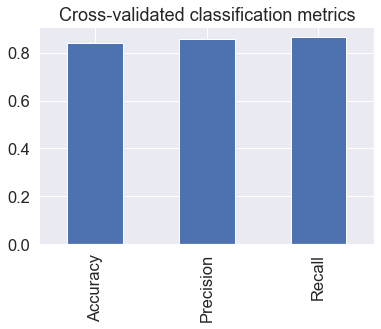

In [36]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                          "Precision": cv_precision,
                          "Recall": cv_recall},
                         index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                    legend=False);

## Heart Disease Risk Application

Now that we have finished picking a model, Logistic Regression, and verified that it meets the appropriate evaluation metrics, the application can be used to predict heart disease risk given patient data. Please select a patient's attributes below and click the "Submit Patient Data for Analysis" button to receive a heart disease risk determination and recommendation.

In [49]:
# Fit an instance of LogisticRegression
clf = LogisticRegression(C=0.38566204211634725,
                        solver="liblinear")
clf.fit(x_train, y_train);

# Widgets for patient data input
from ipywidgets import widgets
from ipywidgets import Layout

widget_style = {'description_width': 'initial'}

sex = widgets.Select(
    options = df.Sex.unique().tolist(),
    description = "Sex", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='40px', display='flex')
)

chest_pain = widgets.Select(
    options = df.ChestPainType.unique().tolist(),
    description = "Chest Pain Type", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='80px', display='flex')
)

resting_ecg = widgets.Select(
    options = df.RestingECG.unique().tolist(),
    description = "Resting ECG", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='60px', display='flex')
)

exercise_angina = widgets.Select(
    options = df.ExerciseAngina.unique().tolist(),
    description = "Exercise Angina", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='40px', display='flex')
)

st_slope = widgets.Select(
    options = df.ST_Slope.unique().tolist(),
    description = "ST_Slope", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='60px', display='flex')
)

age = widgets.IntSlider(
    value=50,
    min=0,
    max=100,
    step=1,
    description="Age", style=widget_style,
    disabled=False
)

resting_bp = widgets.IntSlider(
    value=120,
    min=0,
    max=200,
    step=1,
    description="Resting Blood Pressure", style=widget_style,
    disabled=False
)

cholesterol = widgets.IntSlider(
    value=100,
    min=0,
    max=700,
    step=1,
    description="Cholesterol", style=widget_style,
    disabled=False
)

fasting_bs = widgets.Select(
    options = df.FastingBS.unique().tolist(),
    description = "Fasting Blood Sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)", style = widget_style,
    disabled = False,
    layout = Layout(width='50%', height='40px', display='flex')
)

max_hr = widgets.IntSlider(
    value=170,
    min=60,
    max=220,
    step=1,
    description="Max Heart Rate", style=widget_style,
    disabled=False
)

oldpeak = widgets.FloatSlider(
    value=1.0,
    min=-7.0,
    max=7.0,
    step=0.1,
    description="Oldpeak", style=widget_style,
    disabled=False
)

sex

Select(description='Sex', layout=Layout(display='flex', height='40px', width='50%'), options=('M', 'F'), style…

In [50]:
chest_pain

Select(description='Chest Pain Type', layout=Layout(display='flex', height='80px', width='50%'), options=('ATA…

In [51]:
resting_ecg

Select(description='Resting ECG', layout=Layout(display='flex', height='60px', width='50%'), options=('Normal'…

In [52]:
exercise_angina

Select(description='Exercise Angina', layout=Layout(display='flex', height='40px', width='50%'), options=('N',…

In [53]:
st_slope

Select(description='ST_Slope', layout=Layout(display='flex', height='60px', width='50%'), options=('Up', 'Flat…

In [54]:
age

IntSlider(value=50, description='Age', style=SliderStyle(description_width='initial'))

In [55]:
resting_bp

IntSlider(value=120, description='Resting Blood Pressure', max=200, style=SliderStyle(description_width='initi…

In [56]:
cholesterol

IntSlider(value=100, description='Cholesterol', max=700, style=SliderStyle(description_width='initial'))

In [57]:
fasting_bs

Select(description='Fasting Blood Sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)', layout=Layout(display='f…

In [58]:
max_hr

IntSlider(value=170, description='Max Heart Rate', max=220, min=60, style=SliderStyle(description_width='initi…

In [59]:
oldpeak

FloatSlider(value=1.0, description='Oldpeak', max=7.0, min=-7.0, style=SliderStyle(description_width='initial'…

In [61]:
#Button for submitting patient data and displaying heart disease prediction
from IPython.display import display

button = widgets.Button(description="Submit Patient Data for Analysis", layout=Layout(width="50%"))
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    
    test_array = []
    
    if sex.value == "F":
        test_array.extend([1, 0])
    if sex.value == "M":
        test_array.extend([0, 1])
    if chest_pain.value == "ASY":
        test_array.extend([1, 0, 0, 0])
    if chest_pain.value == "ATA":
        test_array.extend([0, 1, 0, 0])
    if chest_pain.value == "NAP":
        test_array.extend([0, 0, 1, 0])
    if chest_pain.value == "TA":
        test_array.extend([0, 0, 0, 1])
    if resting_ecg.value == "LVH":
        test_array.extend([1, 0, 0])
    if resting_ecg.value == "Normal":
        test_array.extend([0, 1, 0])
    if resting_ecg.value == "ST":
        test_array.extend([0, 0, 1])
    if exercise_angina.value == "N":
        test_array.extend([1, 0])
    if exercise_angina.value == "Y":
        test_array.extend([0, 1])
    if st_slope.value == "Down":
        test_array.extend([1, 0, 0])
    if st_slope.value == "Flat":
        test_array.extend([0, 1, 0])
    if st_slope.value == "Up":
        test_array.extend([0, 0, 1])
    test_array.extend([age.value, resting_bp.value, cholesterol.value, fasting_bs.value, max_hr.value, oldpeak.value])
    
    test_array = np.array(test_array)
    test_array = test_array.reshape(1, -1)
    pred = clf.predict(test_array)
    result = ""
    if pred == 0:
        result = "Unlikely to be at risk for heart disease. Schedule follow-up appointment, but warn the patient that their appointment may be rescheduled to make room for at risk patients."
    if pred == 1:
        result = "At risk for heart disease. Schedule appointment as soon as possible and reschedule patients without risk if necessary."
    
    with output:
        print(result)

button.on_click(on_button_clicked)

Button(description='Submit Patient Data for Analysis', layout=Layout(width='50%'), style=ButtonStyle())

Output()